## import library

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# df['summary]와 df['keyword']를 python 기반 한국어 토크나이저를 불러와서 토큰화
from konlpy.tag import Okt
from sklearn.decomposition import PCA

In [2]:
# 현재 파일 위치
path = os.getcwd() + '/2-3. 키워드 별 유사도 도출/output/merge/'
with open(os.getcwd() + '/stopwords.txt', 'r', encoding='cp949') as f:
    stopwords = f.readlines()

okt = Okt()

# path 내 파일 리스트 출력
file_list = os.listdir(path)
file_list

['final_test_gs_analysis.csv',
 'final_test_hyun_analysis.csv',
 'final_test_lg_analysis.csv',
 'final_test_lot_analysis.csv',
 'final_test_sin_analysis.csv']

In [104]:
df = pd.read_csv(path + file_list[4], encoding='utf-8-sig')

# date 기준으로 정렬
df = df.sort_values(by='date', ascending=False)
df = df.reset_index(drop=True)
# pre_label.1 drop
df = df.drop(['pre_label.1'], axis=1)
# NaN 값 0으로
df = df.fillna(0)

df

,date,abstract,pre_label,sentiment,score,sent_range,model_keyword,corpus_keyword
0,2023-01-13,"“5천원부터 그냥 줍니다” 27만명이나 챙긴 ‘용돈벌이’ 몰랐어? [지구, 뭐......",1,0,2.529453,보통부정,갤러리아백화점 롯데백화점,
1,2023-01-13,폭탄세일 때만 손님 몰려…'행사 대박'에도 웃지 못하는 마트 신동빈 롯데 회장과 정...,0,0,1.818684,중립,0,0
2,2023-01-13,인증서·공연 티켓·멤버십 카드 대체···'유틸리티 NFT'가 뜬다 앞서 신세계백화점...,0,1,1.980132,중립,0,0
3,2023-01-13,"신세계 백화점서 4억 넘게 쓴 VIP 손님, 이런 '특별혜택' 받는답니다 최근 한 ...",0,1,1.931253,중립,0,0
4,2023-01-13,"기준금리 또 인상…돈 빌릴까 고심 깊어지는 식품업계 단체급식, 외식, 식자재 납품업...",0,0,2.125655,약한부정,0,0
...,...,...,...,...,...,...,...,...
2555,2022-01-03,"'물어보살' 임성민, 스승 제이블랙 전화에 붉어진 눈시울 ""잘 지내고 있어"" 24살...",1,1,2.050638,중립,생방송투데이 자족식당,
2556,2022-01-03,"정용진 신세계그룹 부회장, ""머리 아닌 심장으로 생각하라""....'제2의 월마트.....",0,1,1.931253,중립,0,0
2557,2022-01-03,"넷플릭스 예능 '솔로지옥', '고요의 바다' 제치고 1위 ●'마트 방역패스' 앞두고...",0,1,2.050638,중립,0,0
2558,2022-01-03,"유통가, 임인년 맞아 호랑이 마케팅 '열기' 신세계백화점은 임인년을 맞아 전 점에서...",0,1,2.169164,약한긍정,0,0


In [105]:
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(8 ,6))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

# 한글폰트 세팅
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [106]:
#df = pd.read_csv(path + file_list[5], encoding='cp949')


# df의 label 별로 df 생성하는 for문
#    for i in range(len(esg_word)):
df_1 = df[df['pre_label'] == 1]
df_1 = df_1.reset_index(drop=True)

df_2 = df[df['pre_label'] == 2]
df_2 = df_2.reset_index(drop=True)

df_3 = df[df['pre_label'] == '3']
df_3 = df_3.reset_index(drop=True)


### E에 대한 키워드 유사도

In [107]:
df_1['agg'] = df_1['abstract'] + df_1['corpus_keyword']

# sumarry와 keyword를 합쳐서 토큰화
tokenized_doc = df_1['agg'].apply(lambda x: okt.morphs(x, stem=True)) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stopwords]) # 불용어 제거

# keyword에 대해서만 word embedding을 위해 단어 추출 및 통합 과정
split_word = df_1['corpus_keyword'].apply(lambda x: okt.morphs(x, stem=True))
split_word = split_word[split_word.apply(lambda x: len(x) > 0)]
# split_word index 초기화
split_word = split_word.reset_index(drop=True)
# split_word의 각 행의 첫 번째, 두 번째 단어 뽑기
split_word = split_word.apply(lambda x: x[:2])
# split_word의 각 행의 단어 합치기
split_word_agg = split_word.apply(lambda x: ' '.join(x))


In [108]:
# tokenized_doc에 구분된 keyword 단어에 대해 다시 합치기
for j in range(len(split_word_agg)):
    tokenized_doc = tokenized_doc.apply(lambda x: [split_word_agg[j] if item == split_word[j][0] else item for item in x])


In [109]:
vocabs = split_word_agg.tolist()

# vocabs 내 '협력 사'를 제거
vocabs = [x for x in vocabs if x != '협력 사']
#vocabs = [x.replace('협력 사', '협력 회사') for x in vocabs]

c:\Users\MLCF\anaconda3\envs\bk\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


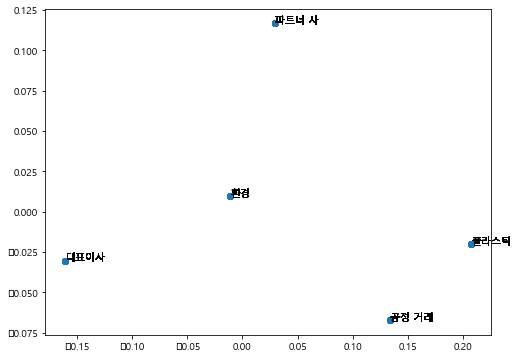

In [110]:

# model 정의 : sg = 0은 CBOW, sg = 1은 Skip-gram
model = Word2Vec(tokenized_doc, vector_size=100, window=5, min_count=1, workers=4, sg = 1)
word_vectors = model.wv

word_vectors_list = [word_vectors[v] for v in vocabs]

pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

# 결과
plot_2d_graph(vocabs, xs, ys)

# word_vectors npy로 저장
import numpy as np

output_path = os.getcwd() + '/2-3. 키워드 별 유사도 도출/output/merge/output/' + file_list[4] + '/e/'

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
np.save(output_path + 'word_vectors.npy', word_vectors_list)
np.save(output_path + 'vocabs.npy', vocabs)

### S에 대한 키워드 유사도

c:\Users\MLCF\anaconda3\envs\bk\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


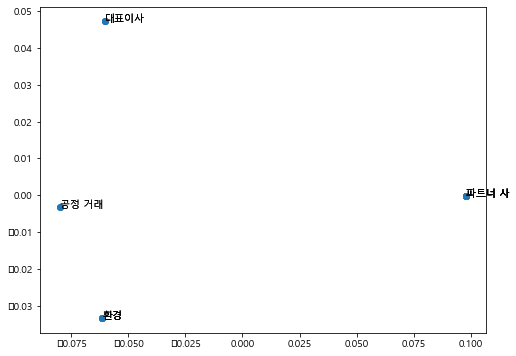

In [111]:
df_2['agg'] = df_2['abstract'] + df_2['corpus_keyword']

# sumarry와 keyword를 합쳐서 토큰화
tokenized_doc = df_2['agg'].apply(lambda x: okt.morphs(x, stem=True)) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stopwords]) # 불용어 제거

# keyword에 대해서만 word embedding을 위해 단어 추출 및 통합 과정
split_word = df_2['corpus_keyword'].apply(lambda x: okt.morphs(x, stem=True))
# split_word의 각 행의 첫 번째, 두 번째 단어 뽑기
split_word = split_word.apply(lambda x: x[:2])
split_word = split_word[split_word.apply(lambda x: len(x) > 0)]
# split_word index 초기화
split_word = split_word.reset_index(drop=True)
# split_word의 각 행의 첫 번째, 두 번째 단어 뽑기
split_word = split_word.apply(lambda x: x[:2])
# split_word의 각 행의 단어 합치기
split_word_agg = split_word.apply(lambda x: ' '.join(x))

# tokenized_doc에 구분된 keyword 단어에 대해 다시 합치기
for j in range(len(split_word_agg)):
    tokenized_doc = tokenized_doc.apply(lambda x: [split_word_agg[j] if item == split_word[j][0] else item for item in x])

# model 정의 : sg = 0은 CBOW, sg = 1은 Skip-gram

vocabs = split_word_agg.tolist()

model = Word2Vec(tokenized_doc, vector_size=100, window=5, min_count=1, workers=4, sg = 1)
word_vectors = model.wv

word_vectors_list = [word_vectors[v] for v in vocabs]
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

# 결과
plot_2d_graph(vocabs, xs, ys)

output_path = os.getcwd() + '/2-3. 키워드 별 유사도 도출/output/merge/output/' + file_list[4] + '/s/'

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
np.save(output_path + 'word_vectors.npy', word_vectors_list)
np.save(output_path + 'vocabs.npy', vocabs)

### G에 대한 키워드 유사도

In [54]:
df_3['agg'] = df_3['abstract'] + df_3['corpus_keyword']

# sumarry와 keyword를 합쳐서 토큰화
tokenized_doc = df_3['agg'].apply(lambda x: okt.morphs(x, stem=True)) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stopwords]) # 불용어 제거

# keyword에 대해서만 word embedding을 위해 단어 추출 및 통합 과정
split_word = df_3['corpus_keyword'].apply(lambda x: okt.morphs(x, stem=True))
# split_word의 각 행의 첫 번째, 두 번째 단어 뽑기
split_word = split_word.apply(lambda x: x[:2])
split_word = split_word[split_word.apply(lambda x: len(x) > 0)]
# split_word index 초기화
split_word = split_word.reset_index(drop=True)
# split_word의 각 행의 첫 번째, 두 번째 단어 뽑기
split_word = split_word.apply(lambda x: x[:2])
# split_word의 각 행의 단어 합치기
split_word_agg = split_word.apply(lambda x: ' '.join(x))

# tokenized_doc에 구분된 keyword 단어에 대해 다시 합치기
for j in range(len(split_word_agg)):
    tokenized_doc = tokenized_doc.apply(lambda x: [split_word_agg[j] if item == split_word[j][0] else item for item in x])

vocabs = split_word_agg.tolist()

# model 정의 : sg = 0은 CBOW, sg = 1은 Skip-gram
model = Word2Vec(tokenized_doc, vector_size=100, window=5, min_count=1, workers=4, sg = 1)
word_vectors = model.wv

word_vectors_list = [word_vectors[v] for v in vocabs]

pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

# 결과
plot_2d_graph(vocabs, xs, ys)

output_path = os.getcwd() + '/2-3. 키워드 별 유사도 도출/output/merge/output/' + file_list[1] + '/g/'

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
np.save(output_path + 'word_vectors.npy', word_vectors_list)
np.save(output_path + 'vocabs.npy', vocabs)

Series([], Name: agg, dtype: object)


RuntimeError: you must first build vocabulary before training the model